# A Variational Autoencoder for Single Cell Transcriptomics in the CELLxGENE Dataset

This notebook complements the source code for a variational autoencoder (VAE) on the CELLxGENE Dataset. It is part of the course "Big Data Praktikum" at Leipzig University. In this notebook, we document our data pipeline and comment on decisions and experiences we made during the implementation. The notebook includes python code for illustrative purposes, but the main training pipeline is contained in seperate python scripts optimized for deployment to HPC infrastructure.

## Motivation

Variational autoencoders (VAEs) offer a powerful framework for learning compact, informative representations of high-dimensional gene expression data. Applying a VAE to datasets from the CellXGene Database enables nonlinear dimensionality reduction while preserving biologically meaningful variation across cells. The inferred latent means capture essential cellular features in a lower-dimensional space, facilitating downstream tasks such as visualization, clustering, and trajectory inference.

### Imports

In [5]:
from src.dataloader import SingleCellDataset
from src.vae import CellVAE
from src.utils import plot_latent_scatter, load_model_config
import cellxgene_census
import anndata
import torch
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

## Data loading and preprocessing

### Accessing the CELLxGENE Dataset

We access the CellXGene dabase via its census API. This code snippet provides a brief insight into how the query is parameterized. The database is large and thus access may take some time. Therefore, we provide a script in this repository `data_fetcher.py`, to perform this task efficiently on scientific computing infrastructure. 

In [4]:
with cellxgene_census.open_soma() as census:
    adata = cellxgene_census.get_anndata(
        census, 
        "Homo sapiens",
        obs_coords=slice(0, 100),
        obs_value_filter="tissue_general == 'lung' and disease in ['normal','lung adenocarcinoma', 'squamous cell lung carcinoma', 'small cell lung carcinoma', 'non-small cell lung carcinoma', 'pleomorphic carcinoma', 'lung large cell carcinoma'] and is_primary_data == True",  # Specific tissue
        obs_column_names=["cell_type", "tissue", "disease"]  # Minimal metadata
    )

print(adata)

The "stable" release is currently 2025-01-30. Specify 'census_version="2025-01-30"' in future calls to open_soma() to ensure data consistency.


AnnData object with n_obs × n_vars = 0 × 61888
    obs: 'cell_type', 'tissue', 'disease', 'tissue_general', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'


We carefully selected an example dataset from the CELLxGENE database that balances representativeness, computational feasibility, and biomedical relevance. Our goal was to choose data that reflects the diversity of the broader corpus while remaining manageable given hardware limitations. We prioritized datasets with clinical relevance—particularly in oncology—and included both healthy and cancerous lung cells from various donors across age and sex. To ensure measurement variability and generalizability, the dataset integrates samples from multiple sources. For statistical robustness and usability, we randomly selected 20,000 cells for downstream processing, using soma_joinid to extract their corresponding gene expression data.

## Preprocessing

**Description**

Our pipeline prepares single-cell RNA-seq data from .h5ad files for PyTorch models, with a focus on flexible preprocessing and VAE optimization.
The VAE-optimized preprocessing consists of: <br/>
- Selecting highly variable genes by variance <br/>
- Applying size factor normalization <br/>
- (Optional) clipping <br/>
- Log1p transformation <br/>
- Z-score scaling <br/>

Outside VAE mode, it uses Scanpy for HVG selection, filtering, and optional normalization/log-transform. The result is a modular, training-ready dataset tailored for deep learning tasks.



### Defining the PyTorch Dataset

Training a model with PyTorch is facilitated by using their Dataset and Dataloader API. We define our own SingleCellDataset class that manages an AnnData object of single cell data and exposes it PyTorch. Data preparation is included in the class.

In [8]:
# We defined a convenience function to obtain the correct hyperparamters relating to a specific training run:
config = load_model_config("modelconfigs/example.yaml")

data_file_path = config["data_file_path"]
n_data_samples = 20_000 # different value for inference
scale_factor = config["scale_factor"]
latent_dim = config["latent_dim"]
number_of_features = config["number_of_features"]
use_variance = config["use_variance"]
vae_processing = config["vae_preprocessing"]

# Instantiate the dataset
dataset = SingleCellDataset(
        file_path=data_file_path,
        cell_subset=list(range(n_data_samples)),
        log_transform=True, normalize=True,
        scale_factor=scale_factor,
        remove_outliers=[0.05, 0.95],
        select_n_genes=number_of_features,
        use_vae_preprocessing=vae_processing
    )

Using VAE-optimized preprocessing...
Dataset loaded: 20000 cells × 2000 genes


Inference itself requires a DataLoader. 
As efficiency isn't as important for the single forward pass needed for the inference, we use a batch size of 1.

In [9]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

## Defining the variational autoencoder

### Architecture

We initially had planned to base our VAE on the VASC (https://academic.oup.com/gpb/article/16/5/320/7225045) by Wang et al. However, the complex details of their model were outside of our ability to train successfuly. Therefore we settled on a more simple architecture which we describe below.

The VAE architecture consists of an encoder, a latent space, and a decoder. The encoder transforms high-dimensional input into a compact hidden representation using three fully connected layers with ReLU activations, progressively reducing the dimensionality from input_dim to 64. From this hidden layer, the model computes two separate outputs: the mean (z_mean) and optionally the log-variance (z_logvar) of the latent distribution, both through linear layers of size 64 → latent_dim. The decoder then reconstructs the input by reversing this process through another stack of fully connected layers with ReLU activations, expanding from latent_dim back to input_dim. All linear layers are initialized using Xavier uniform initialization, and biases are set to a small positive value (0.01) to promote stable training.

Schematically, the architecture looks like this:

**Encoder:**
- Linear layer: input_dim → 512
- ReLU activation
- Linear layer: 512 → 256
- ReLU activation
- Linear layer: 256 → 64
- ReLU activation

**Latent space:**
- Mean vector (z_mean): Linear layer 64 → latent_dim
- Log-variance vector (z_logvar): Linear layer 64 → latent_dim (optional, used if use_variance=True)

**Decoder:**
- Linear layer: latent_dim → 64
- ReLU activation
- Linear layer: 64 → 256
- ReLU activation
- Linear layer: 256 → 512
- ReLU activation
- Linear layer: 512 → input_dim (output layer)

**Initialization:**
- All nn.Linear layers use Xavier uniform weight initialization
- All biases are initialized to 0.01

### Definition of the ELBO

Our loss function is based on the formal definition of the VAE and combines RMSE for reconstruction accuracy and KL divergence (KLD) for latent space regularisation.

Specifically:
- RMSE measures the reconstruction error between input x and output recon_x.
- KLD penalizes deviation of the latent distribution from a standard normal.

The final loss is:
ELBO = RMSE + β × KLD,
where β controls the strength of regularization of the encoder. In code, our loss function is implemented as such:
```python
def loss_function(
        self, recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor, beta: float = 1.0
    ):
        """
        ELBO loss = RMSE + beta * KLD.
        """
        batch_size = x.size(0)
        
        if logvar is None:
            logvar = torch.ones_like(mu)

        MSE = F.mse_loss(recon_x, x, reduction='mean')
        RMSE = torch.sqrt(MSE)

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
        return RMSE + beta * KLD, RMSE, KLD
```

## Training the variational autoencoder

Successful training of the VAE requires careful setup and tuning of the training process. We optimize our implementation for training on the Leipzig University Scientific Computing infrastructure[^1] using GPUs via CUDA.

Our main training logic is containd in `train_vae.py`.

Training on the cluster can be initiated using using
 ```bash
sbatch jobfiles/train_1GPU.job
```

[^1]: sc.uni-leipzig.de

### Training infrastructure

**Multi-GPU training**

Our script handles multi-GPU training using PyTorch’s Distributed Data Parallel (DDP) framework, initialized via torchrun. We assign each process to a specific GPU and initialize a process group using the NCCL backend. To ensure each process works on a unique subset of the data, we use a DistributedSampler. We wrap our model in DDP to synchronize gradient updates across all GPUs during training. Logging, evaluation, and model saving are performed only by the main process (rank 0) to avoid duplication. After training, we cleanly shut down the process group to release resources.

**Tracking**

We use Weights and Biases (WandB)[^1] to track important parameters of our model training. WandB offers a simple API to track run-level and epoch-level metrics and artifacts.

```python
# Parameters used to specify a run
wandb.init(
    entity="coyfelix7-universit-t-leipzig",
    project="big_data_vae",
    config={
        "learning_rate": learning_rate,
        "dataset": data_file_path,
        "n_data_samples": n_data_samples,
        "epochs": n_epochs,
        "latent_dim": latent_dim,
        "batch_size": batch_size,
        "vae-beta": beta,
    }
)

# Paramters logged during a run
wandb.log({
    "epoch": epoch,
    "avg_loss": avg_loss,
    "value_rmse": avg_value_rmse,
    "KLD": avg_KLD,
    "learning_rate": optimizer.param_groups[0]['lr']
})
```


[^1]: https://wandb.ai

### Parameterization of the training

For easy of replication and tracking, we parameterize our training using yaml files (example in `modelconfigs/example.yaml`). The final model checkpoint is saved to `models/` with the datetime at save and the configuration name as a filename for later identification. We read the config file via the utility function `load_model_config`, as used above for the dataloader.

### Training statistics

![WandB Example](figures/wandb.png "WandB Example")

The above image shows a screenshot from our Weights and Biases report page for the VAE used in this demonstration. We can see the development of the loss and its components as training progresses. Note that the KL-distance is multiplied by beta (0.005 in our example). We see generally stable training behavior, but note the dip in KL-divergence early on, which could probably be avoided by more tuning of hyperparameters.

## Evaluation of the latent space

We use the VAE as a means of generating well-behaved, expressive latent representations of data samples for later downstream tasks such as classificator training. As such, it is important to evaluate the latent values in detail. We do this, in priciple, by comparing 2D representations generated by different dimensionality reduction algorithms to 2D representations based on the VAE latent means. Additionally, we inspect individual VAE latent means to see if they encode any interpretable data property (disentanglement).

### Obtaining latent representation for the data samples

We first load the trained model weights and perform inference on the dataset.

In [11]:
# Define model
model = CellVAE(input_dim=dataset.n_genes, latent_dim=config["latent_dim"], use_variance=use_variance)

# Load weights
model.load_state_dict(torch.load('models/example.pth', map_location=torch.device('cpu')))

model.eval()

CellVAE(
  (encoder): Sequential(
    (0): Linear(in_features=2000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
  )
  (z_mean): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
  )
  (z_logvar): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=2000, bias=True)
  )
)

We use the VAE encoder (`model.encode()`) to obtain the latent means and latent log variances. We discard the logvars and aggregate the means into a dataframe which we use for downstream analysis.

In [12]:
# obtain latent means on dataset

latent_means = []

with torch.no_grad():
    for idx, data in enumerate(dataloader):
        mu, _ = model.encode(data)
        latent_means.append(mu.cpu().numpy())  # ensure it's on CPU

# Stack all latent vectors into a single NumPy array
latent_array = np.vstack(latent_means)

# Create DataFrame with named columns: z1, z2, ..., zd
n_latents = latent_array.shape[1]
df_latent = pd.DataFrame(latent_array, columns=[f'z{i+1}' for i in range(n_latents)])

print(df_latent.head())


         z1        z2
0  0.212041  0.070364
1  0.324380  0.275147
2  0.280600  0.253191
3  0.278149  0.233620
4  0.254007  0.254137


We annotate the latent means with the respective labels from the dataset. This gives us the ability to color them in scatterplots later. This cell contains an optional generation of dummy VAE results for visualization testing.

In [13]:
# # Optional:
# # Simulate latent means
# latent_values = np.random.randn(n_data_samples, latent_dim)

# # Create DataFrame for latent values
# df_latent = pd.DataFrame(latent_values, columns=[f"z{i+1}" for i in range(latent_dim)])

label_df = dataset.get_cell_metadata()

labeled_latents = pd.concat([label_df.reset_index(drop=True), df_latent], axis=1)

print(labeled_latents.head())
print(labeled_latents.describe())

  tissue disease   sex         cell_type tissue_general        z1        z2
0   lung  normal  male  endothelial cell           lung  0.212041  0.070364
1   lung  normal  male  endothelial cell           lung  0.324380  0.275147
2   lung  normal  male  endothelial cell           lung  0.280600  0.253191
3   lung  normal  male  endothelial cell           lung  0.278149  0.233620
4   lung  normal  male  endothelial cell           lung  0.254007  0.254137
                 z1            z2
count  20000.000000  20000.000000
mean      -0.053043     -0.074743
std        1.092753      1.040581
min       -3.422171     -2.844545
25%       -0.815207     -0.804980
50%       -0.110698     -0.136985
75%        0.636400      0.655354
max        2.799641      3.484951


### Comparison: PCA

The first step in our investigation of the VAE latens is a comparison of the VAE latent representation with the first two principal components of a principal component analysis. PCA describes the data as 'directions' of largest variance. In this step of the analysis, we use 2D scatter plots, colored by our target labels `tissue` and `desease` for a visual comparison between the two methods of dimensionality reduction.

The first step is to calculate the principal components. We do this on the `AnnData` object of our dataset and use the `scanpy` library for the calculation.

In [14]:
adata = dataset.adata.copy()

sc.tl.pca(adata)

For the visualization, we define our own utility method `plot_latent_scatter` that plots our results to a `matplotlib` axes object. We use a 2x2 grid to compare the results of PCA to the VAE latents on the two target variables.

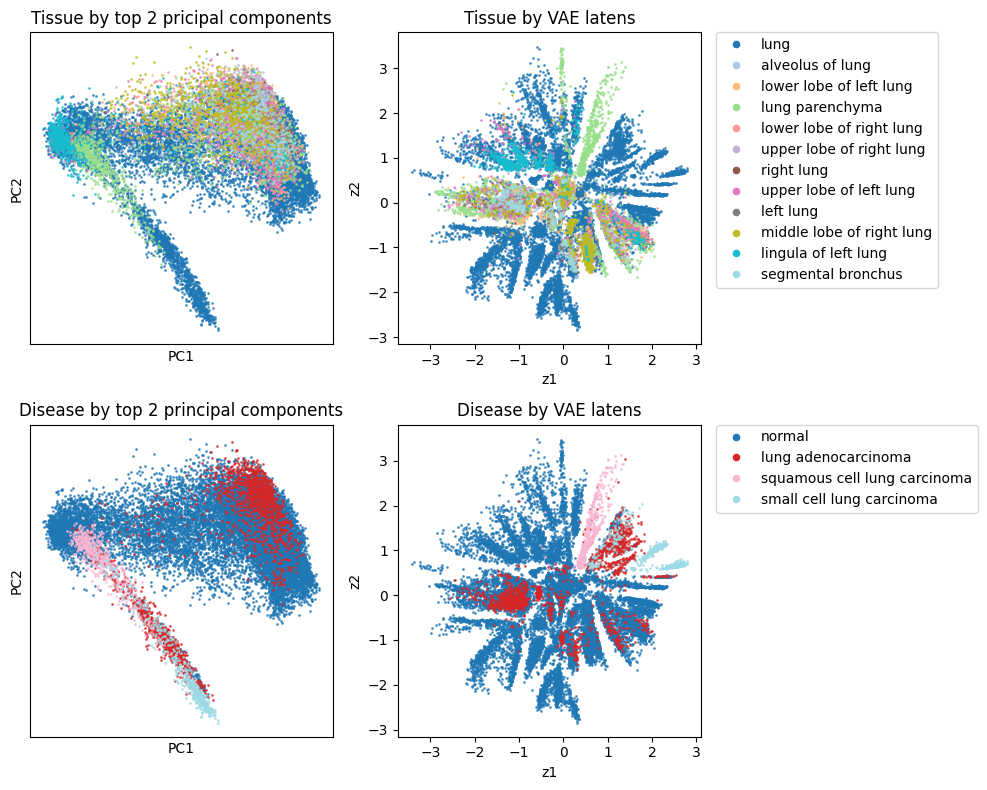

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 

df_pca = pd.DataFrame(adata.obsm['X_pca'], columns=[f'PC{i+1}' for i in range(adata.obsm['X_pca'].shape[1])])
labeled_pca = pd.concat([label_df.reset_index(drop=True), df_pca], axis=1)

plot_latent_scatter(labeled_pca, x='PC1', y='PC2', label_col='tissue', ax=axs[0,0], title='Tissue by top 2 pricipal components', dot_size=1, legend_dot_size=None, ticks=False)
plot_latent_scatter(labeled_pca, x='PC1', y='PC2', label_col='disease', ax=axs[1,0], title='Disease by top 2 principal components', dot_size=1, legend_dot_size=None, ticks=False)
plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='tissue', ax=axs[0,1], title='Tissue by VAE latens', dot_size=1, legend_dot_size=20, ticks=True)
plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='disease', ax=axs[1,1], title='Disease by VAE latens', dot_size=1, legend_dot_size=20, ticks=True)

plt.tight_layout()
plt.show()

**Result interpretation**

Visually, the the 2D latent embeddings achive significantly supperior clustering performace compared to the first two principal components. Two of the disease classes are visually separated well from the rest of the data. This result shows that the VAE is expectedly able to capture more discriminating detail of the data than two-component PCA, due to the capacity of its neural network encoder.

### Comparison: UMAP

Secondly, we compare our VAE embeddings to 2D UMAP embeddings. Uniform manifold approximation (UMAP) is a sophisticated dimensionality reduction technique, that aims to embedd high-dimensional data onto a lower-dimensional manifold while preserving relationships between data points. We use `scanpy`'s integrated umap API to generate the embeddings for our data.

In [16]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

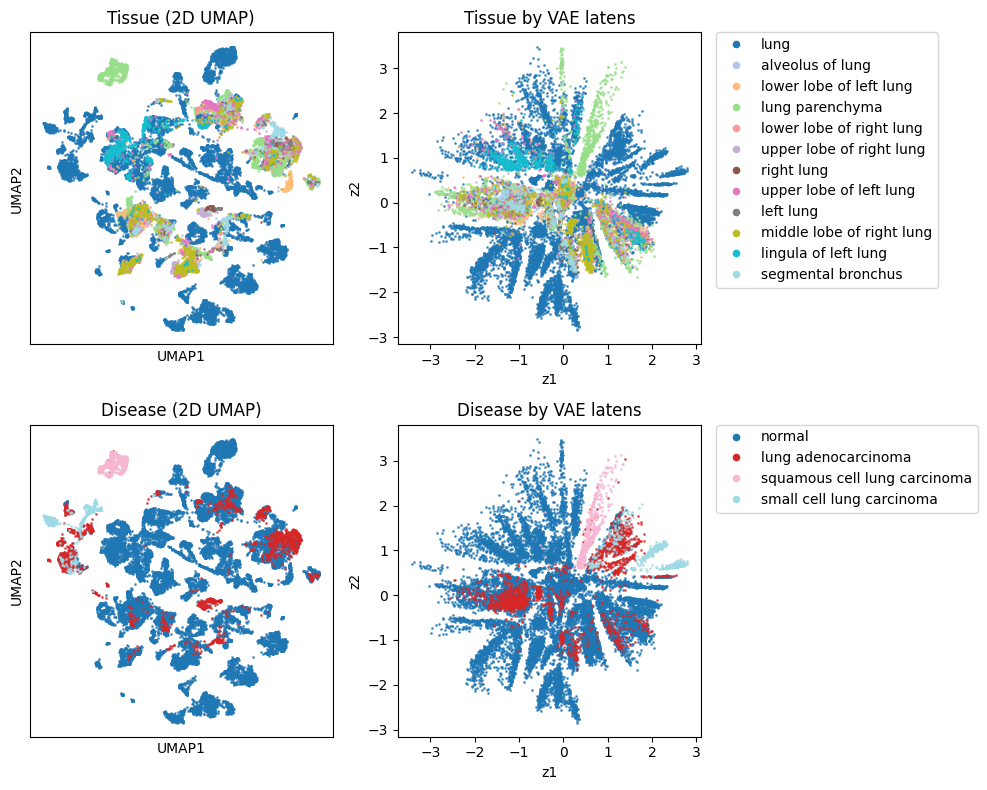

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 

df_umap = pd.DataFrame(adata.obsm['X_umap'], columns=[f'UMAP{i+1}' for i in range(adata.obsm['X_umap'].shape[1])])
labeled_umap = pd.concat([label_df.reset_index(drop=True), df_umap], axis=1)

plot_latent_scatter(labeled_umap, x='UMAP1', y='UMAP2', label_col='tissue', ax=axs[0,0], title='Tissue (2D UMAP)', dot_size=1, legend_dot_size=None, ticks=False)
plot_latent_scatter(labeled_umap, x='UMAP1', y='UMAP2', label_col='disease', ax=axs[1,0], title='Disease (2D UMAP)', dot_size=1, legend_dot_size=None, ticks=False)
plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='tissue', ax=axs[0,1], title='Tissue by VAE latens', dot_size=1, legend_dot_size=20, ticks=True)
plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='disease', ax=axs[1,1], title='Disease by VAE latens', dot_size=1, legend_dot_size=20, ticks=True)

plt.tight_layout()
plt.show()

**Result interpretation**

Visually, the UMAP embeddings are slightly superior to the 2D VAE latents, although that does not constitute an exact quantification. Generally, the two approaches of dimensionality reduction perform fairly similar relating to our target classes, separating the same classes well while struggeling to discriminate others. We can also see the preference of the VAE model to encode on a uncorrelated Gaussian distribution.

## Discussion

Our VAE for gene expression data on the CellXGene dataset achieves good performance on first analysis. In comparison with two other frequently used methods of dimensionality reduction, PCA and UMAP, our model performs visually better or similar. We provide a highly configurable data ingestion and training pipeline, that lends itself for many more interesting experiments that we have unfortunatley not had the time to pursue ourselves. Among others, we would like to further explore

- the effects of different values of beta on the latent space
- quantitative comparison against other dimensionality reduction algorithms in a classification task
- disentanglement capabilites of the model
- higher-dimensional latent spaces